# **Kaggle Challenge: Pirate Pain Dataset 🏴‍☠️ (v7: Conv1d + LR Scheduler)**

This notebook introduces a powerful Conv1d-GRU architecture to break through performance plateaus. It combines 1D convolutions for low-level feature extraction with a GRU for high-level sequence modeling.

**Strategy:**
1.  **Hybrid Feature Input:**
    * **Continuous Features:** 31 `joint_` features + 1 `time` feature are scaled.
    * **Categorical Features:** 4 `pain_survey_` features + 1 `is_pirate` feature are passed to `nn.Embedding` layers.
2.  **Conv1d-GRU Architecture:**
    *   A **`nn.Conv1d`** layer first processes the full sequence of combined features to identify local, time-invariant patterns.
    *   The output sequence from the Conv1d layer is then fed into the **`nn.GRU`** to model longer-term temporal dependencies.
3.  **Advanced Training:**
    *   A **`CosineAnnealingLR`** learning rate scheduler is used to improve convergence and find better minima.
    *   Heavy regularization via two separate `Dropout` layers (one for features, one for the GRU) is used to prevent overfitting.
4.  **Hyperparameter Search:** Ray Tune & Optuna are used to find optimal parameters for the entire Conv1d-GRU stack, including the LR scheduler.
5.  **K-Fold Ensemble:** The best configuration is trained on 5 folds for a robust final prediction.

## ⚙️ 1. Setup & Libraries

In [31]:
# Set seed for reproducibility
SEED = 123

# Import necessary libraries
import os
import logging
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import copy
from itertools import product
import time

# Set environment variables before importing modules
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# --- PyTorch Imports ---
import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader

# --- Sklearn Imports ---
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

# --- Ray[tune] & Optuna Imports ---
import ray
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune.search.optuna import OptunaSearch
from functools import partial

# --- Setup Directories & Device ---
logs_dir = "tensorboard"
os.makedirs("models", exist_ok=True)
os.makedirs("submissions", exist_ok=True)
os.makedirs(logs_dir, exist_ok=True)

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
    print("\n--- Using GPU ---")
else:
    device = torch.device("cpu")
    print("\n--- Using CPU ---")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Configure plot display settings
sns.set_theme(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline


--- Using GPU ---
PyTorch version: 2.5.1
Device: cuda


## 🔄 2. Data Loading & Feature Engineering

In [32]:
print("--- 1. Loading Data ---")

# --- Define File Paths and Features ---
DATA_DIR = "data"
X_TRAIN_PATH = os.path.join(DATA_DIR, "pirate_pain_train.csv")
Y_TRAIN_PATH = os.path.join(DATA_DIR, "pirate_pain_train_labels.csv")
X_TEST_PATH = os.path.join(DATA_DIR, "pirate_pain_test.csv")
SUBMISSION_PATH = os.path.join(DATA_DIR, "sample_submission.csv")

try:
    features_long_df = pd.read_csv(X_TRAIN_PATH)
    labels_df = pd.read_csv(Y_TRAIN_PATH)
    X_test_long_df = pd.read_csv(X_TEST_PATH)
    
    N_TIMESTEPS = 160
    JOINT_FEATURES = [f"joint_{i:02d}" for i in range(31)]
    PAIN_FEATURES = [f"pain_survey_{i}" for i in range(1, 5)]
    TIME_FEATURE = ['time']
    FEATURES = JOINT_FEATURES + PAIN_FEATURES + TIME_FEATURE
    LABEL_MAPPING = {'no_pain': 0, 'low_pain': 1, 'high_pain': 2}
    N_CLASSES = len(LABEL_MAPPING)

    def reshape_data(df, features_list, n_timesteps):
        df_pivot = df.pivot(index='sample_index', columns='time', values=features_list)
        data_2d = df_pivot.values
        n_samples = data_2d.shape[0]
        data_3d = data_2d.reshape(n_samples, len(features_list), n_timesteps)
        return data_3d.transpose(0, 2, 1)

    X_train_full = reshape_data(features_long_df[features_long_df['sample_index'].isin(labels_df['sample_index'].unique())], FEATURES, N_TIMESTEPS)
    X_test_full = reshape_data(X_test_long_df, FEATURES, N_TIMESTEPS)
    y_train_full_df = labels_df.sort_values(by='sample_index')
    le = LabelEncoder().fit(list(LABEL_MAPPING.keys()))
    y_train_full = le.transform(y_train_full_df['label'])
    print(f"Loaded X_train_full (shape: {X_train_full.shape}) and y_train_full (shape: {y_train_full.shape})")
    print(f"Loaded X_test_full (shape: {X_test_full.shape})")

    print("\n--- 2. Engineering 'is_pirate' Feature ---")
    static_cols = ['sample_index', 'n_legs', 'n_hands', 'n_eyes']
    static_df = features_long_df[static_cols].drop_duplicates().set_index('sample_index')
    pirate_filter = (static_df['n_legs'] == 'one+peg_leg') | (static_df['n_hands'] == 'one+hook_hand') | (static_df['n_eyes'] == 'one+eye_patch')
    pirate_indices = static_df[pirate_filter].index
    sample_indices_ordered = sorted(features_long_df[features_long_df['sample_index'].isin(labels_df['sample_index'].unique())]['sample_index'].unique())
    is_pirate_map = np.array([1 if idx in pirate_indices else 0 for idx in sample_indices_ordered])
    pirate_feature_broadcast = np.tile(is_pirate_map.reshape(-1, 1, 1), (1, N_TIMESTEPS, 1))
    X_train_full_engineered = np.concatenate([X_train_full, pirate_feature_broadcast], axis=2)

    static_df_test = X_test_long_df[static_cols].drop_duplicates().set_index('sample_index')
    pirate_filter_test = (static_df_test['n_legs'] == 'one+peg_leg') | (static_df_test['n_hands'] == 'one+hook_hand') | (static_df_test['n_eyes'] == 'one+eye_patch')
    pirate_indices_test = static_df_test[pirate_filter_test].index
    sample_indices_test_ordered = sorted(X_test_long_df['sample_index'].unique())
    is_pirate_map_test = np.array([1 if idx in pirate_indices_test else 0 for idx in sample_indices_test_ordered])
    pirate_feature_broadcast_test = np.tile(is_pirate_map_test.reshape(-1, 1, 1), (1, N_TIMESTEPS, 1))
    X_test_full_engineered = np.concatenate([X_test_full, pirate_feature_broadcast_test], axis=2)
    
    N_FEATURES_NEW = X_train_full_engineered.shape[2]
    print(f"Created X_train_full_engineered (shape: {X_train_full_engineered.shape})")
    print(f"Created X_test_full_engineered (shape: {X_test_full_engineered.shape})")
    print(f"N_FEATURES is now: {N_FEATURES_NEW}")

    print("\n--- 3. Calculating Class Weights ---")
    class_counts_series = labels_df['label'].value_counts()
    counts_ordered = class_counts_series.reindex(LABEL_MAPPING.keys()).values
    class_weights_tensor = 1.0 / torch.tensor(counts_ordered, dtype=torch.float)
    class_weights_tensor = (class_weights_tensor / class_weights_tensor.sum()).to(device)
    print(f"Class counts (0, 1, 2): {counts_ordered}")
    print(f"Calculated class weights: {class_weights_tensor}")

except Exception as e:
    print(f"An error occurred: {e}")

--- 1. Loading Data ---
Loaded X_train_full (shape: (661, 160, 36)) and y_train_full (shape: (661,))
Loaded X_test_full (shape: (1324, 160, 36))

--- 2. Engineering 'is_pirate' Feature ---
Created X_train_full_engineered (shape: (661, 160, 37))
Created X_test_full_engineered (shape: (1324, 160, 37))
N_FEATURES is now: 37

--- 3. Calculating Class Weights ---
Class counts (0, 1, 2): [511  94  56]
Calculated class weights: tensor([0.0643, 0.3493, 0.5864], device='cuda:0')


## 🛠️ 3. Helper Functions

In [33]:
def create_sliding_windows(X_3d, y=None, window_size=100, stride=20):
    new_X, new_y, window_indices = [], [], []
    n_samples, n_timesteps, _ = X_3d.shape
    for i in range(n_samples):
        idx = 0
        while (idx + window_size) <= n_timesteps:
            new_X.append(X_3d[i, idx:idx+window_size, :])
            window_indices.append(i)
            if y is not None: new_y.append(y[i])
            idx += stride
    if y is not None:
        return np.array(new_X), np.array(new_y), np.array(window_indices)
    return np.array(new_X), np.array(window_indices)

def make_loader(ds, batch_size, shuffle, drop_last):
    return DataLoader(ds, batch_size=int(batch_size), shuffle=shuffle, drop_last=drop_last, num_workers=0, pin_memory=True)

## 🧠 4. Model & Training Engine

In [34]:
class RecurrentClassifier(nn.Module):
    def __init__(self, hidden_size, num_layers, num_classes,
                 conv_out_channels, conv_kernel_size, bidirectional,
                 dropout_rate, feature_dropout_rate, rnn_type='GRU'):
        super().__init__()
        self.rnn_type, self.num_layers, self.hidden_size, self.bidirectional = \
            rnn_type, num_layers, hidden_size, bidirectional

        # --- Feature Engineering Layers ---
        self.pain_embed_dim, self.pirate_embed_dim = 4, 4
        self.pain_embeddings = nn.ModuleList([nn.Embedding(3, self.pain_embed_dim) for _ in range(4)])
        self.pirate_embedding = nn.Embedding(2, self.pirate_embed_dim)
        
        num_continuous_features = 32 # 31 joints + 1 time
        total_embedding_dim = (4 * self.pain_embed_dim) + self.pirate_embed_dim
        conv_input_size = num_continuous_features + total_embedding_dim

        # --- Conv1d Layer for Feature Extraction ---
        self.conv1d = nn.Conv1d(in_channels=conv_input_size, out_channels=conv_out_channels,
                                kernel_size=conv_kernel_size, padding='same')
        self.conv_activation = nn.ReLU()
        self.feature_dropout = nn.Dropout(feature_dropout_rate)

        # --- RNN Layer for Sequence Modeling ---
        self.rnn = nn.GRU(
            input_size=conv_out_channels, hidden_size=hidden_size,
            num_layers=num_layers, batch_first=True, bidirectional=bidirectional,
            dropout=dropout_rate if num_layers > 1 else 0)
        
        # --- Classifier Head ---
        self.classifier = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, num_classes)

    def forward(self, x):
        x_continuous = x[:, :, :32]
        x_categorical = x[:, :, 32:].long()
        embedded_cats = [self.pain_embeddings[i](x_categorical[:, :, i]) for i in range(4)] \
                      + [self.pirate_embedding(x_categorical[:, :, 4])]
        x_combined = torch.cat([x_continuous] + embedded_cats, dim=2)
        x_permuted = x_combined.permute(0, 2, 1)
        x_conv = self.conv_activation(self.conv1d(x_permuted))
        x_conv_permuted = x_conv.permute(0, 2, 1)
        x_dropped = self.feature_dropout(x_conv_permuted)
        _, hidden = self.rnn(x_dropped)
        if self.bidirectional:
            hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size)
            hidden = torch.cat([hidden[-1, 0, :, :], hidden[-1, 1, :, :]], dim=1)
        else:
            hidden = hidden[-1]
        return self.classifier(hidden)

def train_one_epoch(model, loader, criterion, optimizer, scaler, device):
    model.train()
    total_loss, all_preds, all_targets = 0, [], []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(x)
            loss = criterion(logits, y)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item() * x.size(0)
        all_preds.append(logits.argmax(dim=1).cpu().numpy())
        all_targets.append(y.cpu().numpy())
    return total_loss / len(loader.dataset.tensors[0]), f1_score(np.concatenate(all_targets), np.concatenate(all_preds), average='weighted')

def validate_one_epoch(model, loader, criterion, device):
    model.eval()
    total_loss, all_preds, all_targets = 0, [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(x)
                loss = criterion(logits, y)
            total_loss += loss.item() * x.size(0)
            all_preds.append(logits.argmax(dim=1).cpu().numpy())
            all_targets.append(y.cpu().numpy())
    return total_loss / len(loader.dataset.tensors[0]), f1_score(np.concatenate(all_targets), np.concatenate(all_preds), average='weighted')

def objective_function(config, X_train, y_train, X_val, y_val, class_weights):
    continuous_indices = list(range(32))
    preprocessor = ColumnTransformer([('scaler', StandardScaler(), continuous_indices)], remainder='passthrough')
    ns, ts, f = X_train.shape
    X_train_final = preprocessor.fit_transform(X_train.reshape(ns * ts, f)).reshape(ns, ts, -1)
    ns_val, ts_val, f_val = X_val.shape
    X_val_final = preprocessor.transform(X_val.reshape(ns_val * ts_val, f_val)).reshape(ns_val, ts_val, -1)

    X_train_w, y_train_w, _ = create_sliding_windows(X_train_final, y_train, config["window_size"], config["stride"])
    X_val_w, y_val_w, _ = create_sliding_windows(X_val_final, y_val, config["window_size"], config["stride"])
    train_loader = make_loader(TensorDataset(torch.from_numpy(X_train_w).float(), torch.from_numpy(y_train_w).long()), config["batch_size"], True, True)
    val_loader = make_loader(TensorDataset(torch.from_numpy(X_val_w).float(), torch.from_numpy(y_val_w).long()), config["batch_size"], False, False)

    model_config = {
        'hidden_size': config['hidden_size'], 'num_layers': config['num_layers'],
        'conv_out_channels': config['conv_out_channels'], 'conv_kernel_size': config['conv_kernel_size'],
        'bidirectional': config['bidirectional'], 'dropout_rate': config['dropout_rate'],
        'feature_dropout_rate': config['feature_dropout_rate']
    }
    model = RecurrentClassifier(**model_config, num_classes=N_CLASSES, rnn_type='GRU').to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=config["lr"], weight_decay=config["l2_lambda"])
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=150)
    scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    best_val_f1 = -1.0
    patience_counter = 0
    # Set a fixed patience for all HPO trials
    hpo_patience = 20  
    
    for epoch in range(1, 151):
        train_loss, _ = train_one_epoch(model, train_loader, criterion, optimizer, scaler, device)
        _, val_f1 = validate_one_epoch(model, val_loader, criterion, device)
        tune.report({"val_f1": val_f1, "train_loss": train_loss})
        scheduler.step()

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= hpo_patience:
                print(f"Trial early stopping at epoch {epoch}")
                break # Stop training

def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scheduler, scaler, device, patience, experiment_name):
    model_path = f"models/{experiment_name}_best_model.pt"
    best_f1 = -1
    patience_counter = 0
    print(f"--- Starting Training: {experiment_name} ---")
    for epoch in range(1, epochs + 1):
        train_loss, train_f1 = train_one_epoch(model, train_loader, criterion, optimizer, scaler, device)
        val_loss, val_f1 = validate_one_epoch(model, val_loader, criterion, device)
        scheduler.step()

        if epoch % 25 == 0: print(f"Epoch {epoch:3d}/{epochs} | Val F1: {val_f1:.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")

        if val_f1 > best_f1:
            best_f1, patience_counter = val_f1, 0
            torch.save(model.state_dict(), model_path)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}. Best F1: {best_f1:.4f}")
                break
    print(f"--- Finished Training --- Best F1: {best_f1:.4f}")
    model.load_state_dict(torch.load(model_path))
    return model

## 🧪 5. Phase 1: Hyperparameter Search

In [35]:
# Re-order columns: 32 continuous (joints+time), then 5 categorical (pain+pirate)
continuous_indices_orig = list(range(31)) + [35]
categorical_indices_orig = list(range(31, 35)) + [36]
X_train_full_reordered = np.concatenate([
    X_train_full_engineered[:, :, continuous_indices_orig],
    X_train_full_engineered[:, :, categorical_indices_orig]
], axis=2)
print(f"Re-ordered X_train_full shape: {X_train_full_reordered.shape}")

# --- Split the re-ordered data ---
print("\n--- Splitting re-ordered, unscaled data for HPO ---")
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
for train_idx, val_idx in sss.split(X_train_full_reordered, y_train_full):
    X_train_split, y_train_split = X_train_full_reordered[train_idx], y_train_full[train_idx]
    X_val_split, y_val_split = X_train_full_reordered[val_idx], y_train_full[val_idx]
print(f"  X_train_split: {X_train_split.shape}\n  X_val_split:   {X_val_split.shape}")

Re-ordered X_train_full shape: (661, 160, 37)

--- Splitting re-ordered, unscaled data for HPO ---
  X_train_split: (528, 160, 37)
  X_val_split:   (133, 160, 37)


In [ ]:
search_space = {
    "window_size": tune.choice([10]), "stride": tune.choice([2]),
    "lr": tune.loguniform(1e-4, 5e-3), "batch_size": tune.choice([64, 128]),
    "hidden_size": tune.choice([256, 384]), "num_layers": tune.choice([2, 3]),
    "dropout_rate": tune.uniform(0.1, 0.5), "feature_dropout_rate": tune.uniform(0.2, 0.5),
    "bidirectional": tune.choice([True, False]), "l2_lambda": tune.loguniform(1e-7, 1e-4),
    "conv_out_channels": tune.choice([64, 128]), "conv_kernel_size": tune.choice([3, 5, 7]),
}

def short_trial_name(trial): return f"{trial.trainable_name}_{trial.trial_id}"

if ray.is_initialized(): ray.shutdown()
ray.init(num_cpus=16, num_gpus=1, ignore_reinit_error=True, log_to_driver=False)

print("Starting hyperparameter search...")
analysis = tune.run(
    tune.with_parameters(objective_function, X_train=X_train_split, y_train=y_train_split, X_val=X_val_split, y_val=y_val_split, class_weights=class_weights_tensor),
    resources_per_trial={"cpu": 4, "gpu": 0.25}, config=search_space, num_samples=30,
    search_alg=OptunaSearch(metric="val_f1", mode="max"),
    scheduler=ASHAScheduler(metric="val_f1", mode="max", grace_period=25, reduction_factor=2),
    name="pirate_pain_conv1d_search_v7", verbose=1,
    trial_dirname_creator=short_trial_name
)


2025-11-13 13:55:08,424	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/Users/Karim Negm/ray_results/pirate_pain_conv1d_search_v7' in 0.0480s.
2025-11-13 13:55:08,438	INFO tune.py:1041 -- Total run time: 5526.11 seconds (5525.99 seconds for the tuning loop).



--- Search Complete ---

Getting best trial from analysis...


AttributeError: 'Trial' object has no attribute 'best_result'

In [ ]:
print("\n--- Search Complete ---\n")
print("Getting best trial from analysis...")
best_trial = analysis.get_best_trial(metric="val_f1", mode="max", scope="all")
if best_trial:
    FINAL_CONFIG = best_trial.config
    FINAL_BEST_VAL_F1 = best_trial.last_result["val_f1"]
    print(f"Best validation F1 score: {FINAL_BEST_VAL_F1:.4f}")
    print("Best hyperparameters found:")
    print(FINAL_CONFIG)
else:
    print("ERROR: No trials completed successfully. Using a default config.")
    FINAL_CONFIG = {'window_size': 20, 'stride': 1, 'lr': 0.00045, 'batch_size': 64, 'hidden_size': 384, 'num_layers': 2, 'dropout_rate': 0.2, 'feature_dropout_rate': 0.45, 'bidirectional': True, 'l2_lambda': 1e-06, 'conv_out_channels': 64, 'conv_kernel_size': 7}

del X_train_split, y_train_split, X_val_split, y_val_split


--- Search Complete ---

Getting best trial from analysis...
Best validation F1 score: 0.9395
Best hyperparameters found:
{'window_size': 10, 'stride': 2, 'lr': 0.0021821719477903866, 'batch_size': 128, 'hidden_size': 256, 'num_layers': 2, 'dropout_rate': 0.4263716438404701, 'feature_dropout_rate': 0.44438270547130976, 'bidirectional': True, 'l2_lambda': 1.6092289023228805e-07, 'conv_out_channels': 128, 'conv_kernel_size': 5}


In [39]:
# Have to redefine because I don't want to rerun the whole HPO cell again
FINAL_CONFIG = {'window_size': 10, 'stride': 2, 'lr': 0.0021821719477903866, 'batch_size': 128, 'hidden_size': 256, 'num_layers': 2, 'dropout_rate': 0.4263716438404701, 'feature_dropout_rate': 0.44438270547130976, 'bidirectional': True, 'l2_lambda': 1.6092289023228805e-07, 'conv_out_channels': 128, 'conv_kernel_size': 5}
FINAL_BEST_VAL_F1 = 0.9395

In [40]:
# --- Create a final training and test set ---
print("\n--- Creating Final Train/Test Split (90/10) ---")
sss_final = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=SEED)

# The split is on the full reordered dataset before k-fold starts
for train_idx, test_idx in sss_final.split(X_train_full_reordered, y_train_full):
    X_train_final, y_train_final = X_train_full_reordered[train_idx], y_train_full[train_idx]
    X_test_final, y_test_final = X_train_full_reordered[test_idx], y_train_full[test_idx]

print(f"  X_train_final shape: {X_train_final.shape}")
print(f"  y_train_final shape: {y_train_final.shape}")
print(f"  X_test_final shape:  {X_test_final.shape}")
print(f"  y_test_final shape:  {y_test_final.shape}")

# K-Fold will now run on the X_train_final and y_train_final sets.
# The final ensemble will be tested on X_test_final and y_test_final.


--- Creating Final Train/Test Split (90/10) ---
  X_train_final shape: (594, 160, 37)
  y_train_final shape: (594,)
  X_test_final shape:  (67, 160, 37)
  y_test_final shape:  (67,)


## 🏆 6. Phase 2: K-Fold Ensemble Training

In [42]:
print("--- 🏆 Final Configuration Set --- ")
print(f"Best Val F1 from HPO search: {FINAL_BEST_VAL_F1:.4f}")
print(FINAL_CONFIG)

N_SPLITS = 5
FINAL_EXPERIMENT_NAME = f"Conv1d-GRU_H{FINAL_CONFIG['hidden_size']}_L{FINAL_CONFIG['num_layers']}_" \
                      f"C{FINAL_CONFIG['conv_out_channels']}_K{FINAL_CONFIG['conv_kernel_size']}_v7.1"
submission_filename_base = f"submission_{FINAL_EXPERIMENT_NAME}.csv"
print(f"Submission name will be: {submission_filename_base}")

--- 🏆 Final Configuration Set --- 
Best Val F1 from HPO search: 0.9395
{'window_size': 10, 'stride': 2, 'lr': 0.0021821719477903866, 'batch_size': 128, 'hidden_size': 256, 'num_layers': 2, 'dropout_rate': 0.4263716438404701, 'feature_dropout_rate': 0.44438270547130976, 'bidirectional': True, 'l2_lambda': 1.6092289023228805e-07, 'conv_out_channels': 128, 'conv_kernel_size': 5}
Submission name will be: submission_Conv1d-GRU_H256_L2_C128_K5_v7.1.csv


In [43]:
# MODIFICATION: Changed skf.split to use the new train/test split
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
fold_val_f1_list = []
continuous_indices_reordered = list(range(32))
EPOCHS = 350

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_final, y_train_final)):
    fold_name = f"{FINAL_EXPERIMENT_NAME}_fold_{fold+1}"
    print(f"\n--- Fold {fold+1}/{N_SPLITS} --- ({fold_name}) ---")
    
    # MODIFICATION: Indexing into the new X_train_final and y_train_final sets
    X_train_fold, y_train_fold = X_train_final[train_idx], y_train_final[train_idx]
    X_val_fold, y_val_fold = X_train_final[val_idx], y_train_final[val_idx]

    preprocessor_fold = ColumnTransformer([('s', StandardScaler(), continuous_indices_reordered)], remainder='passthrough')
    ns, ts, f = X_train_fold.shape
    X_train_scaled = preprocessor_fold.fit_transform(X_train_fold.reshape(ns*ts, f)).reshape(ns, ts, f)
    ns_val, ts_val, f_val = X_val_fold.shape
    X_val_scaled = preprocessor_fold.transform(X_val_fold.reshape(ns_val*ts_val, f_val)).reshape(ns_val, ts_val, f_val)
    
    X_train_w, y_train_w, _ = create_sliding_windows(X_train_scaled, y_train_fold, FINAL_CONFIG['window_size'], FINAL_CONFIG['stride'])
    X_val_w, y_val_w, _ = create_sliding_windows(X_val_scaled, y_val_fold, FINAL_CONFIG['window_size'], FINAL_CONFIG['stride'])
    train_loader = make_loader(TensorDataset(torch.from_numpy(X_train_w).float(), torch.from_numpy(y_train_w).long()), FINAL_CONFIG['batch_size'], True, True)
    val_loader = make_loader(TensorDataset(torch.from_numpy(X_val_w).float(), torch.from_numpy(y_val_w).long()), FINAL_CONFIG['batch_size'], False, False)

    model_config_kfold = {k: v for k, v in FINAL_CONFIG.items() if k not in ['window_size', 'stride', 'lr', 'batch_size', 'l2_lambda']}
    model_fold = RecurrentClassifier(**model_config_kfold, num_classes=N_CLASSES).to(device)
    
    optimizer = torch.optim.AdamW(model_fold.parameters(), lr=FINAL_CONFIG['lr'], weight_decay=FINAL_CONFIG['l2_lambda'])
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
    scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

    model_fold = fit(model_fold, train_loader, val_loader, EPOCHS, criterion, optimizer, scheduler, scaler, device, 50, fold_name)
    _, val_f1 = validate_one_epoch(model_fold, val_loader, criterion, device)
    fold_val_f1_list.append(val_f1)
    print(f"Fold {fold+1} Final Val F1: {val_f1:.4f}")

print(f"\n--- 🏆 K-Fold Training Complete --- Average F1: {np.mean(fold_val_f1_list):.4f}")


--- Fold 1/5 --- (Conv1d-GRU_H256_L2_C128_K5_v7.1_fold_1) ---
--- Starting Training: Conv1d-GRU_H256_L2_C128_K5_v7.1_fold_1 ---
Epoch  25/350 | Val F1: 0.9276 | LR: 0.002155
Epoch  50/350 | Val F1: 0.9283 | LR: 0.002074
Epoch  75/350 | Val F1: 0.9307 | LR: 0.001944
Early stopping at epoch 93. Best F1: 0.9402
--- Finished Training --- Best F1: 0.9402
Fold 1 Final Val F1: 0.9402

--- Fold 2/5 --- (Conv1d-GRU_H256_L2_C128_K5_v7.1_fold_2) ---
--- Starting Training: Conv1d-GRU_H256_L2_C128_K5_v7.1_fold_2 ---
Epoch  25/350 | Val F1: 0.9184 | LR: 0.002155
Epoch  50/350 | Val F1: 0.9099 | LR: 0.002074
Early stopping at epoch 60. Best F1: 0.9239
--- Finished Training --- Best F1: 0.9239
Fold 2 Final Val F1: 0.9239

--- Fold 3/5 --- (Conv1d-GRU_H256_L2_C128_K5_v7.1_fold_3) ---
--- Starting Training: Conv1d-GRU_H256_L2_C128_K5_v7.1_fold_3 ---
Epoch  25/350 | Val F1: 0.9290 | LR: 0.002155
Epoch  50/350 | Val F1: 0.9255 | LR: 0.002074
Early stopping at epoch 66. Best F1: 0.9378
--- Finished Traini

## 📬 7. Phase 3: Ensemble Submission

In [50]:
print("\n--- Preparing test dataset for submission ---")
continuous_indices_orig = list(range(31)) + [35]
categorical_indices_orig = list(range(31, 35)) + [36]
X_test_full_reordered = np.concatenate([
    X_test_full_engineered[:, :, continuous_indices_orig],
    X_test_full_engineered[:, :, categorical_indices_orig]], axis=2)

continuous_indices_reordered = list(range(32))
preprocessor_final = ColumnTransformer([('scaler', StandardScaler(), continuous_indices_reordered)], remainder='passthrough')
preprocessor_final.fit(X_train_full_reordered.reshape(-1, N_FEATURES_NEW))

ns_test, ts_test, f_test = X_test_full_reordered.shape
X_test_scaled = preprocessor_final.transform(X_test_full_reordered.reshape(ns_test * ts_test, f_test)).reshape(ns_test, ts_test, f_test)
X_test_w, test_window_indices = create_sliding_windows(X_test_scaled, y=None, window_size=FINAL_CONFIG['window_size'], stride=FINAL_CONFIG['stride'])
test_loader = make_loader(TensorDataset(torch.from_numpy(X_test_w).float()), FINAL_CONFIG['batch_size'], False, False)

model_config_final = {k: v for k, v in FINAL_CONFIG.items() if k not in ['window_size', 'stride', 'lr', 'batch_size', 'l2_lambda']}
all_fold_probabilities = []
for fold in range(N_SPLITS):
    fold_name = f"{FINAL_EXPERIMENT_NAME}_fold_{fold+1}"
    model_path = f"models/{fold_name}_best_model.pt"
    print(f"Loading model {fold+1}/{N_SPLITS} from {model_path}...")
    model_fold = RecurrentClassifier(**model_config_final, num_classes=N_CLASSES).to(device)
    model_fold.load_state_dict(torch.load(model_path, map_location=device))
    model_fold.eval()
    
    fold_preds = []
    with torch.no_grad():
        for (inputs,) in test_loader:
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                probs = torch.softmax(model_fold(inputs.to(device)), dim=1)
                fold_preds.append(probs.cpu().numpy())
    all_fold_probabilities.append(np.concatenate(fold_preds))

mean_probabilities = np.mean(all_fold_probabilities, axis=0)
df_probs = pd.DataFrame(mean_probabilities, columns=[f"prob_{i}" for i in range(N_CLASSES)])
df_probs['original_index'] = test_window_indices
agg_probs = df_probs.groupby('original_index')[[f"prob_{i}" for i in range(N_CLASSES)]].mean().values
final_predictions = le.inverse_transform(np.argmax(agg_probs, axis=1))

submission_df = pd.DataFrame({'sample_index': sorted(X_test_long_df['sample_index'].unique()), 'label': final_predictions})
submission_df['sample_index'] = submission_df['sample_index'].apply(lambda x: f"{x:03d}")
submission_filepath = os.path.join("submissions", submission_filename_base)
submission_df.to_csv(submission_filepath, index=False)
print(f"\nSuccessfully saved to {submission_filepath}!")
print(submission_df.head())


--- Preparing test dataset for submission ---
Loading model 1/5 from models/Conv1d-GRU_H256_L2_C128_K5_v7.1_fold_1_best_model.pt...
Loading model 2/5 from models/Conv1d-GRU_H256_L2_C128_K5_v7.1_fold_2_best_model.pt...
Loading model 3/5 from models/Conv1d-GRU_H256_L2_C128_K5_v7.1_fold_3_best_model.pt...
Loading model 4/5 from models/Conv1d-GRU_H256_L2_C128_K5_v7.1_fold_4_best_model.pt...
Loading model 5/5 from models/Conv1d-GRU_H256_L2_C128_K5_v7.1_fold_5_best_model.pt...

Successfully saved to submissions\submission_Conv1d-GRU_H256_L2_C128_K5_v7.1.csv!
  sample_index    label
0          000  no_pain
1          001  no_pain
2          002  no_pain
3          003  no_pain
4          004  no_pain



--- Evaluating the ensemble on the held-out test set ---
Loading model 1/5 from models/Conv1d-GRU_H256_L2_C128_K5_v7.1_fold_1_best_model.pt for test evaluation...
Loading model 2/5 from models/Conv1d-GRU_H256_L2_C128_K5_v7.1_fold_2_best_model.pt for test evaluation...
Loading model 3/5 from models/Conv1d-GRU_H256_L2_C128_K5_v7.1_fold_3_best_model.pt for test evaluation...
Loading model 4/5 from models/Conv1d-GRU_H256_L2_C128_K5_v7.1_fold_4_best_model.pt for test evaluation...
Loading model 5/5 from models/Conv1d-GRU_H256_L2_C128_K5_v7.1_fold_5_best_model.pt for test evaluation...

--- Final Test Set Performance Metrics ---
--- Overall Performance ---
  - Accuracy:                   0.9254
  - Weighted F1-Score:          0.9177
  - Matthews Correlation Coef:  0.7884
  - Cohen's Kappa:              0.7747

--- Detailed Classification Report ---
              precision    recall  f1-score   support

   high_pain       1.00      0.50      0.67         6
    low_pain       0.88      0.78  

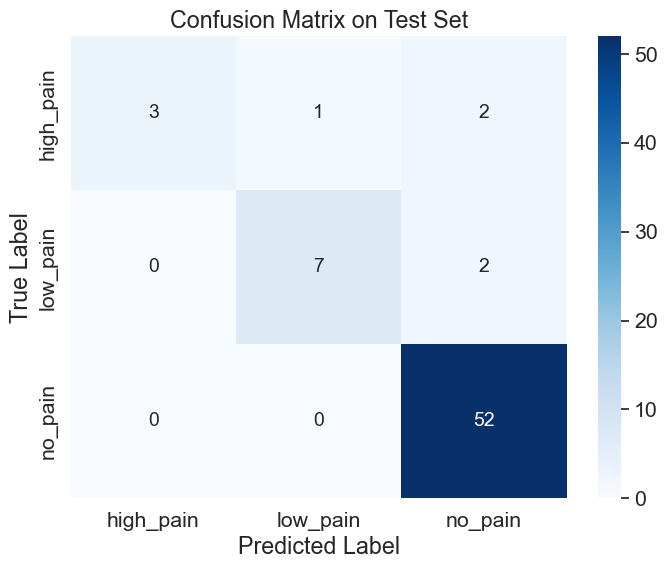

In [52]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report, cohen_kappa_score, matthews_corrcoef
print("\n--- Evaluating the ensemble on the held-out test set ---")

# The preprocessor_final was fitted on the full training data before the split.
# We now use it to transform our held-out test set.
ns_test, ts_test, f_test = X_test_final.shape
X_test_final_scaled = preprocessor_final.transform(X_test_final.reshape(ns_test * ts_test, f_test)).reshape(ns_test, ts_test, f_test)

# Create sliding windows for the test set
X_test_w_final, test_window_indices_final = create_sliding_windows(
    X_test_final_scaled, y=None, window_size=FINAL_CONFIG['window_size'], stride=FINAL_CONFIG['stride']
)
test_loader_final = make_loader(TensorDataset(torch.from_numpy(X_test_w_final).float()), FINAL_CONFIG['batch_size'], False, False)

# --- Make predictions with the ensemble ---
model_config_eval = {k: v for k, v in FINAL_CONFIG.items() if k not in ['window_size', 'stride', 'lr', 'batch_size', 'l2_lambda']}
all_fold_probabilities_test = []

for fold in range(N_SPLITS):
    fold_name = f"{FINAL_EXPERIMENT_NAME}_fold_{fold+1}"
    model_path = f"models/{fold_name}_best_model.pt"
    print(f"Loading model {fold+1}/{N_SPLITS} from {model_path} for test evaluation...")
    
    model_fold = RecurrentClassifier(**model_config_eval, num_classes=N_CLASSES).to(device)
    model_fold.load_state_dict(torch.load(model_path, map_location=device))
    model_fold.eval()
    
    fold_preds = []
    with torch.no_grad():
        for (inputs,) in test_loader_final:
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                probs = torch.softmax(model_fold(inputs.to(device)), dim=1)
                fold_preds.append(probs.cpu().numpy())
    all_fold_probabilities_test.append(np.concatenate(fold_preds))

# --- Aggregate predictions and calculate metrics ---
mean_probabilities_test = np.mean(all_fold_probabilities_test, axis=0)

# Aggregate window predictions back to original sample predictions
df_probs_test = pd.DataFrame(mean_probabilities_test, columns=[f"prob_{i}" for i in range(N_CLASSES)])
df_probs_test['original_index'] = test_window_indices_final
agg_probs_test = df_probs_test.groupby('original_index')[[f"prob_{i}" for i in range(N_CLASSES)]].mean().values
final_test_predictions = np.argmax(agg_probs_test, axis=1)
class_names = le.inverse_transform(range(N_CLASSES))

# --- Calculate and Display Performance Metrics ---
print("\n--- Final Test Set Performance Metrics ---")

# Overall scores
test_accuracy = accuracy_score(y_test_final, final_test_predictions)
test_f1_weighted = f1_score(y_test_final, final_test_predictions, average='weighted')
test_mcc = matthews_corrcoef(y_test_final, final_test_predictions)
test_kappa = cohen_kappa_score(y_test_final, final_test_predictions)

print("--- Overall Performance ---")
print(f"  - Accuracy:                   {test_accuracy:.4f}")
print(f"  - Weighted F1-Score:          {test_f1_weighted:.4f}")
print(f"  - Matthews Correlation Coef:  {test_mcc:.4f}")
print(f"  - Cohen's Kappa:              {test_kappa:.4f}")


# Class-by-class report
print("\n--- Detailed Classification Report ---")
class_report = classification_report(y_test_final, final_test_predictions, target_names=class_names)
print(class_report)


# --- Display Confusion Matrix ---
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test_final, final_test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Set')
plt.show()